# Enantiomer Analysis

In this notebook, we will try to analyze whether the descriptors are capable of correctly clustering enantiomers.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from descriptor_utils import DescriptorWrapper
from experiment_utils import compute_knn, plot_evaluation, compute_descriptors_from_file

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
descriptor_list = [
    'evrap', 'sirm', 'scomp', 'samp', 'sector_model', 'shell_model', 'combined_model',
    'pfh', 'sirm_3d', 'scomp_3d', 'samp_3d'
]
with open(f"point_clouds/proteins.pkl", "rb") as f:
    data = pickle.load(f)
point_clouds = data['objects']
labels = data['labels']

In [4]:
np_labels = np.array(labels)
np.unique(np_labels, return_counts=True)

(array([0, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 9, 44, 27, 11, 43, 19, 67, 23,  1]))

We will pick clusters 3 and 7 to mirror with for particular reason, expect for their size.

In [5]:
for i in range(len(labels)):
    label = labels[i]
    if label == 3 or label == 7:
        mirrored_pc = point_clouds[i].copy()
        mirrored_pc[:, 2] = -mirrored_pc[:, 2]
        point_clouds.append(mirrored_pc)
        labels.append(-label)

In [33]:
descriptor_wrapper = DescriptorWrapper()
descriptor_embeddings = dict()

for descriptor in descriptor_list:
    desc_output = descriptor_wrapper.compute_model_on_dataset(point_clouds, descriptor)
    # need to convert for saving and loading
    desc_output = desc_output.tolist()
    descriptor_embeddings[descriptor] = desc_output

df = pd.DataFrame({k: list(v) for k, v in descriptor_embeddings.items()})
df["labels"] = labels
df.to_csv("test_output/proteins_mirrored.csv")

Previous tests have shown that clustering works best on symmetric, unweighted knn graphs, so we will use them

In [36]:
knn_types = ['symmetric', 'mutual']
descriptors = [
    ['evrap', 'samp', 'sirm', 'scomp'], ['pfh'], ['sector_model'], ['combined_model'],
    ['shell_model'], ['evrap'], ['samp'], ['sirm'], ['scomp'], ['samp_3d'], ['sirm_3d'], ['scomp_3d']
]

pickle_file = f"test_output/protein_mirrored_15_connectivity_nmi_ari.pkl"
if os.path.isfile(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
else:
    data = {
        metric: {'_'.join(descriptor): [] for descriptor in descriptors}
        for metric in ['nmi', 'ari']
    }
    data['cluster_size'] = []

    cluster_size = range(2, 21)
    for c in cluster_size:
        data['cluster_size'].append(c)
        for descriptor in descriptors:
            knn_graph = compute_knn(df, descriptor_list=descriptor, n_neighbors=15, variant='symmetric',
                                    mode='connectivity')

            spectral = SpectralClustering(
                n_clusters=c,
                affinity='precomputed',
                random_state=42,
                n_jobs=-1
            )
            predicted_labels = spectral.fit_predict(knn_graph)
            nmi = normalized_mutual_info_score(df["labels"], predicted_labels)
            ari = adjusted_rand_score(df["labels"], predicted_labels)

            data['nmi']['_'.join(descriptor)].append(nmi)
            data['ari']['_'.join(descriptor)].append(ari)
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarnin

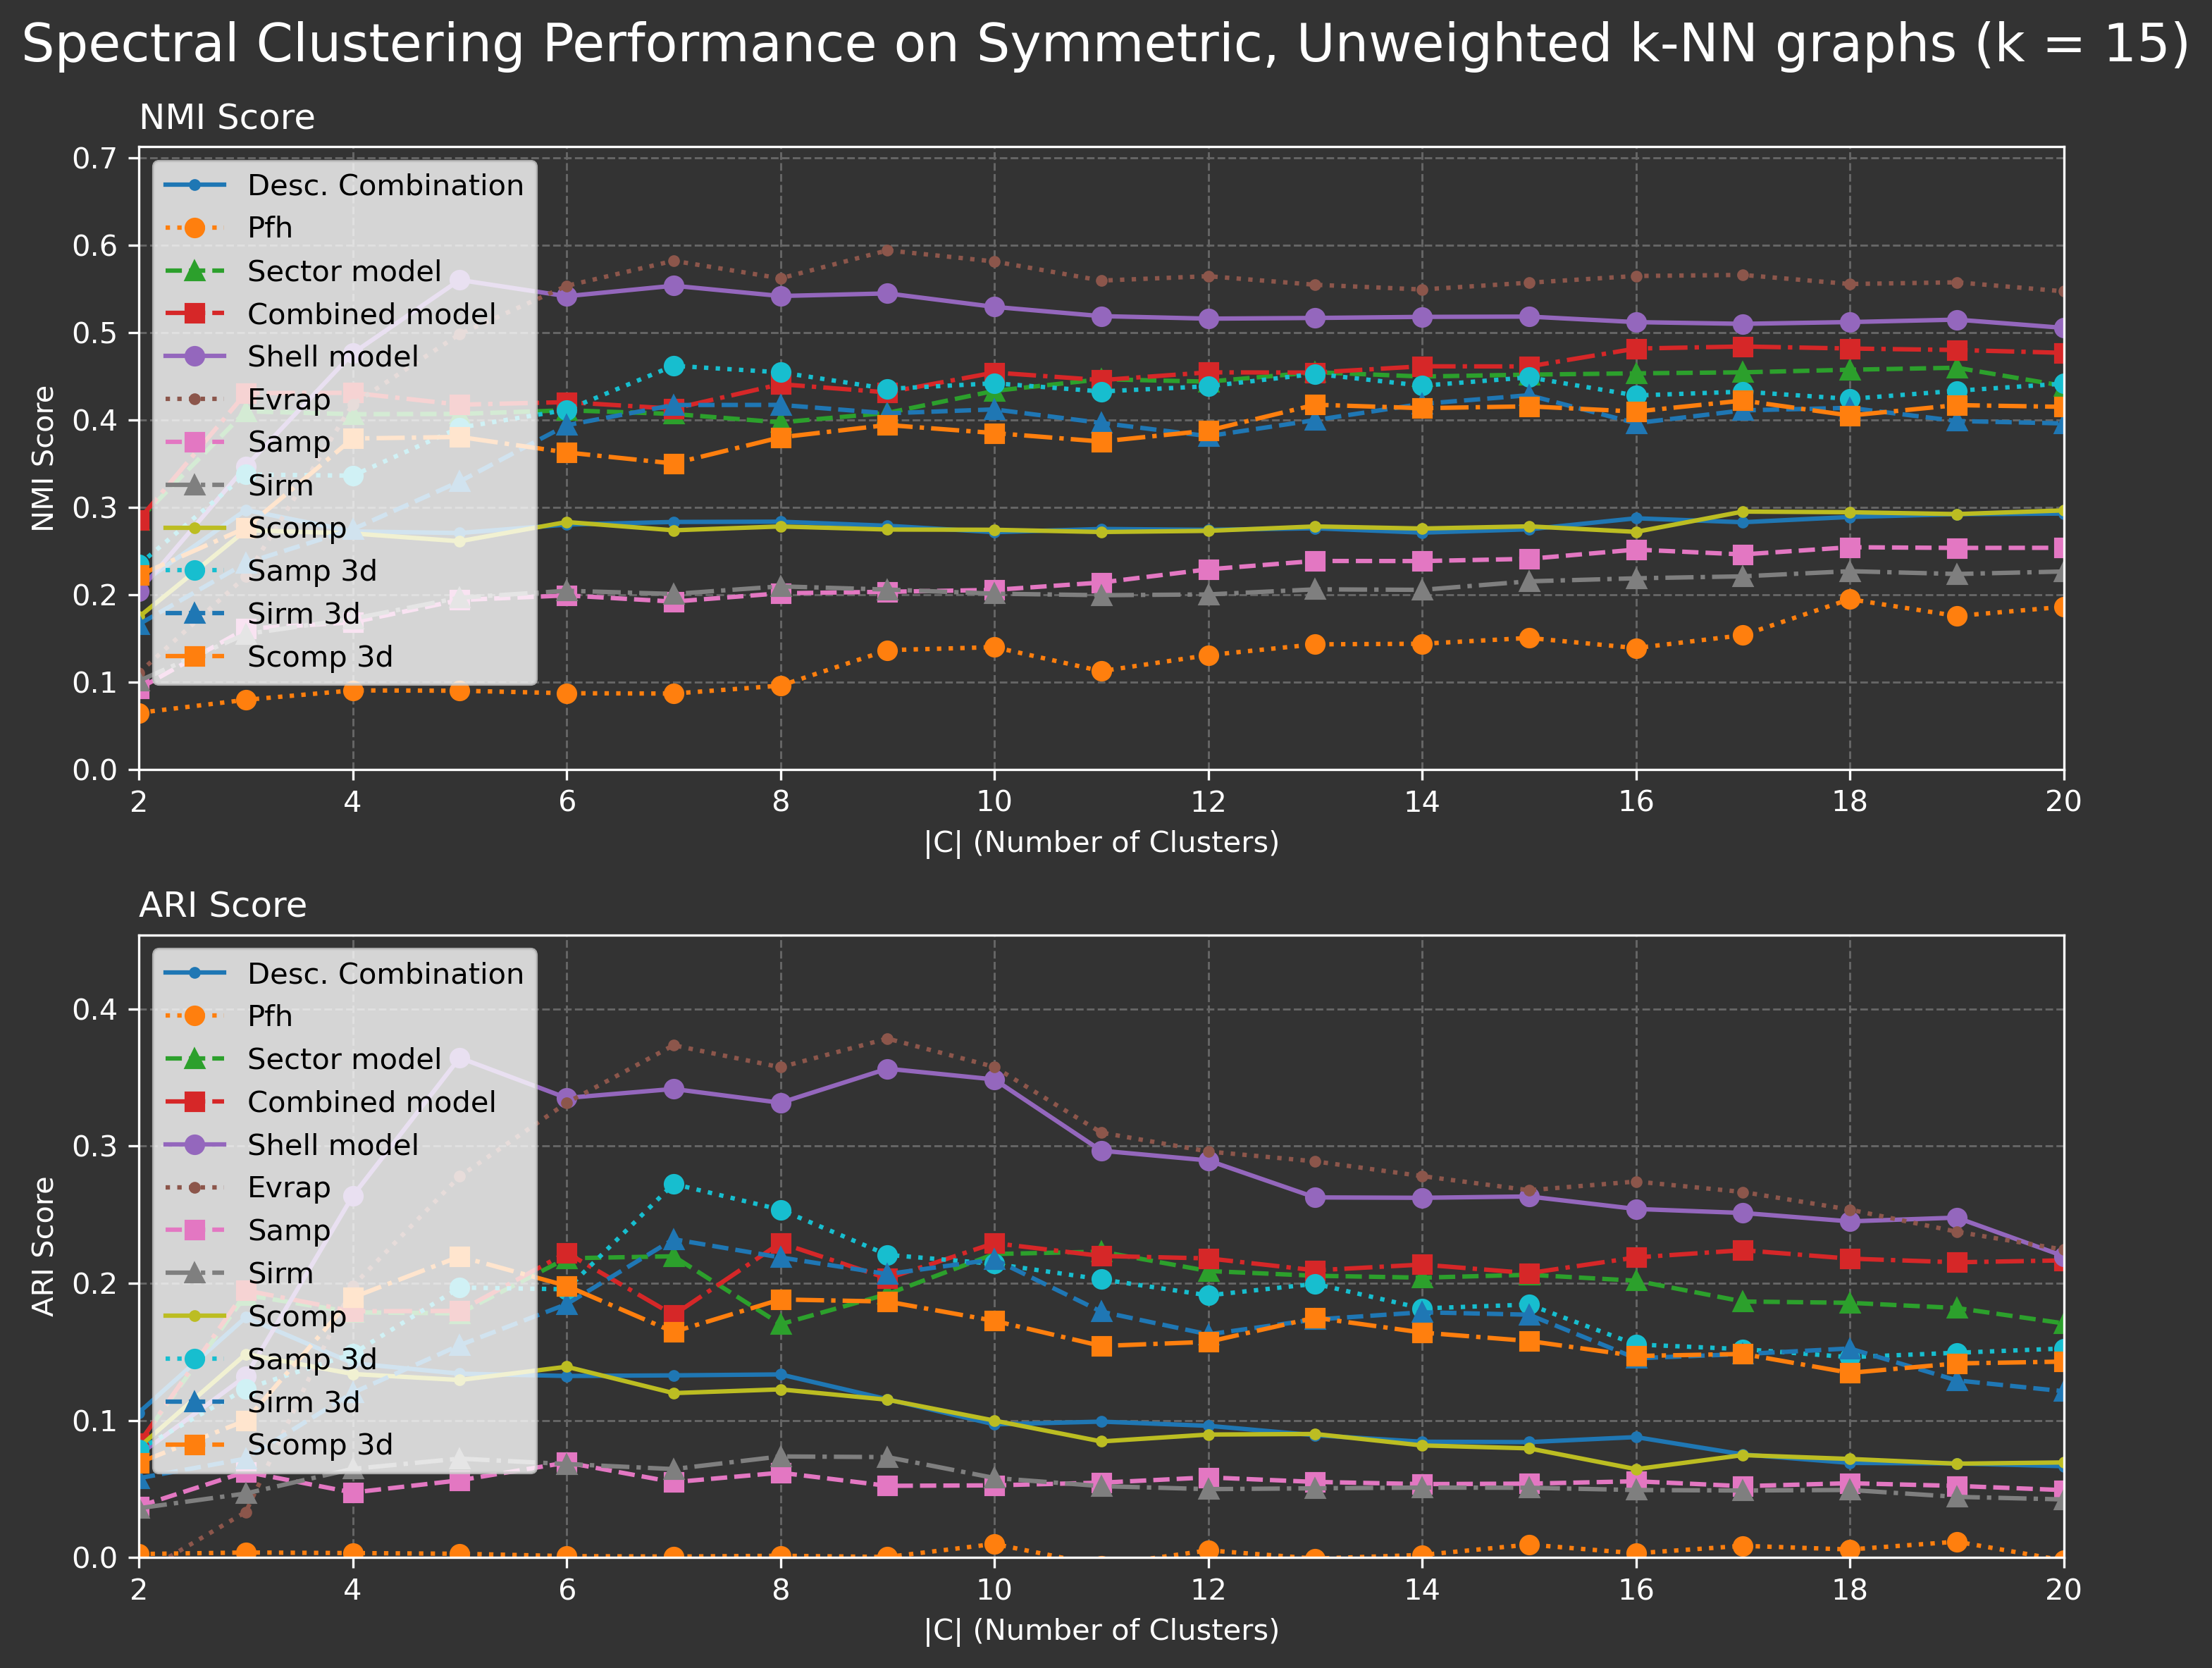

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)  # Example with a 2x2 grid of subplots

plot_evaluation(axes[0], descriptors, data['nmi'], data['cluster_size'],
                x_label='|C| (Number of Clusters)', y_label='NMI Score',
                title='NMI Score')

plot_evaluation(axes[1], descriptors, data['ari'], data['cluster_size'],
                x_label='|C| (Number of Clusters)', y_label='ARI Score',
                title='ARI Score')

fig.suptitle(
    f"Spectral Clustering Performance on Symmetric, Unweighted k-NN graphs (k = 15)",
    color="white", fontsize=18, x=0.01, horizontalalignment="left"
)

fig.patch.set_facecolor('#333333')
fig.tight_layout()

plt.savefig(f"figures/proteins/nmi_ari/unweighted_symmetric_knn_nmi_ari_k15_mirrored.png")
plt.show()

In [3]:
df = compute_descriptors_from_file('proteins_mirrored')

In [4]:
def create_scatterplot_2d(ax, plot_data_x, plot_data_y, plot_labels, label_x='', label_y=''):
    # Map classes to colors
    unique_classes = plot_labels.unique()
    colors = plt.cm.tab10(range(len(unique_classes)))
    class_color_map = dict(zip(unique_classes, colors))

    # Plot points by class
    for class_label in unique_classes:
        class_data_x = plot_data_x[plot_labels == class_label]
        class_data_y = plot_data_y[plot_labels == class_label]
        ax.scatter(
            class_data_x, class_data_y,
            color=class_color_map[class_label], label=class_label, s=50
        )
        
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)

    ax.set_facecolor('#333333')

    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')

    ax.grid(True)
    ax.grid(color='#666666', linestyle='--', linewidth=0.7)

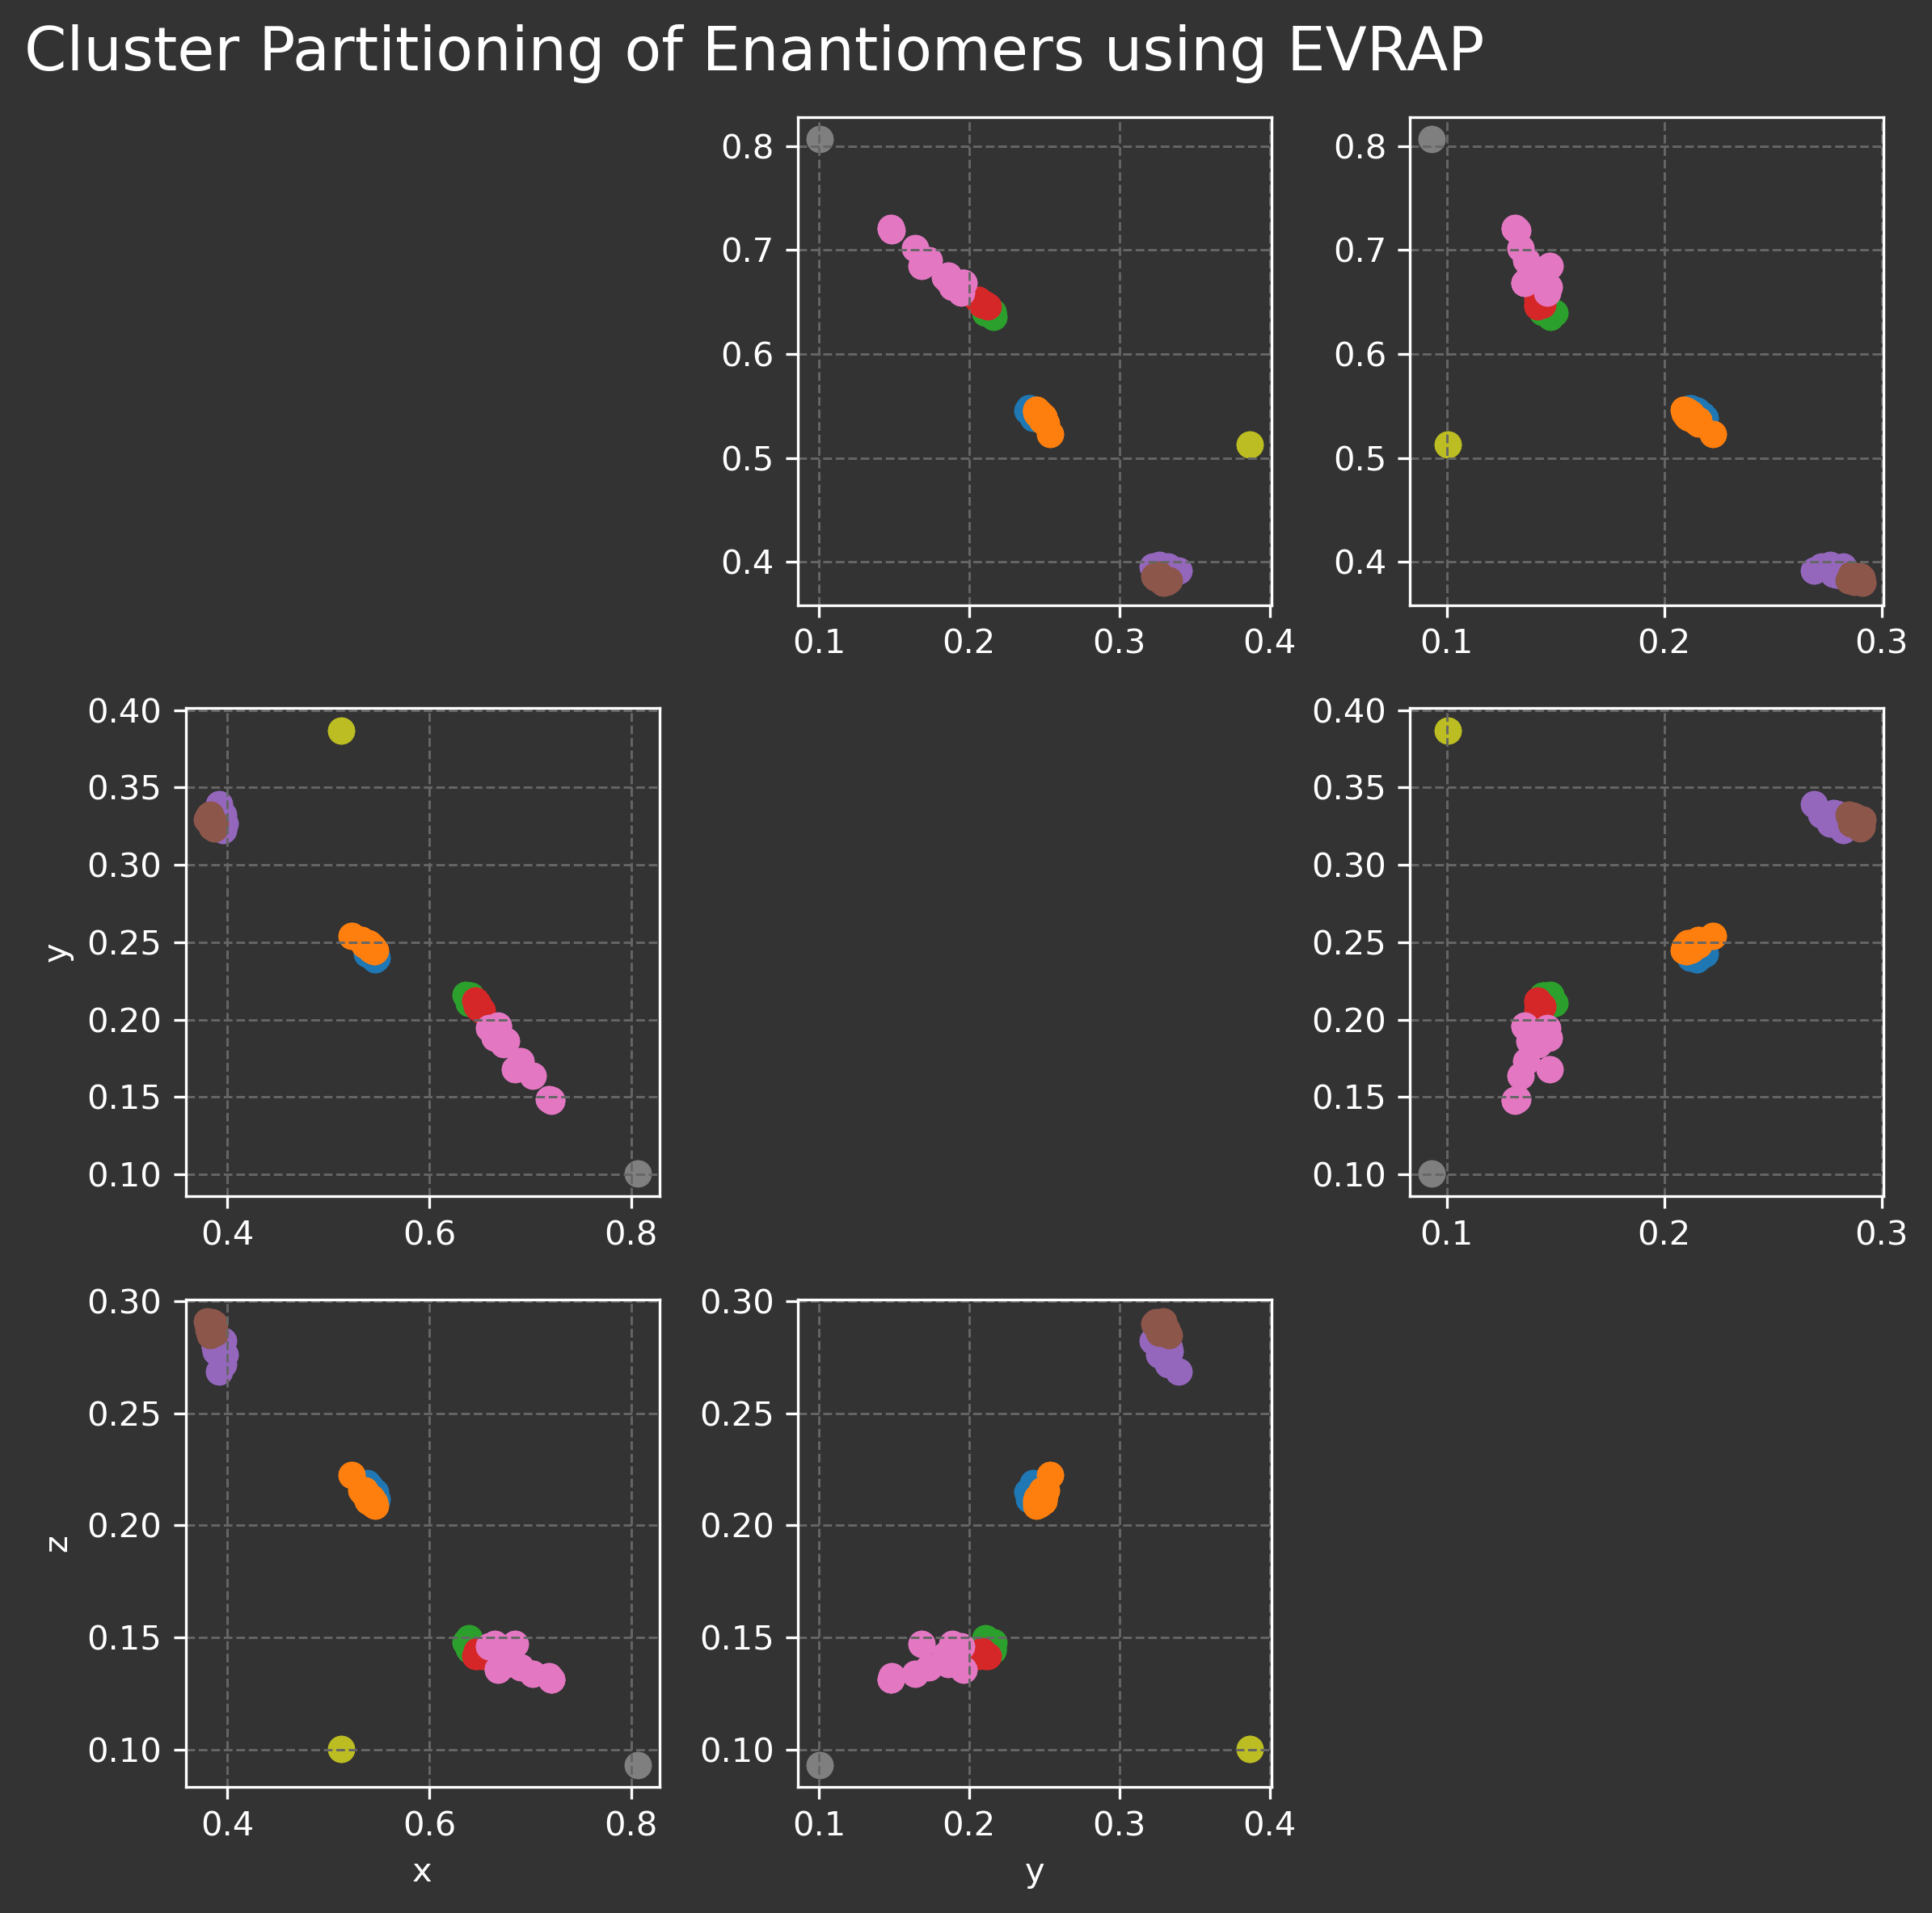

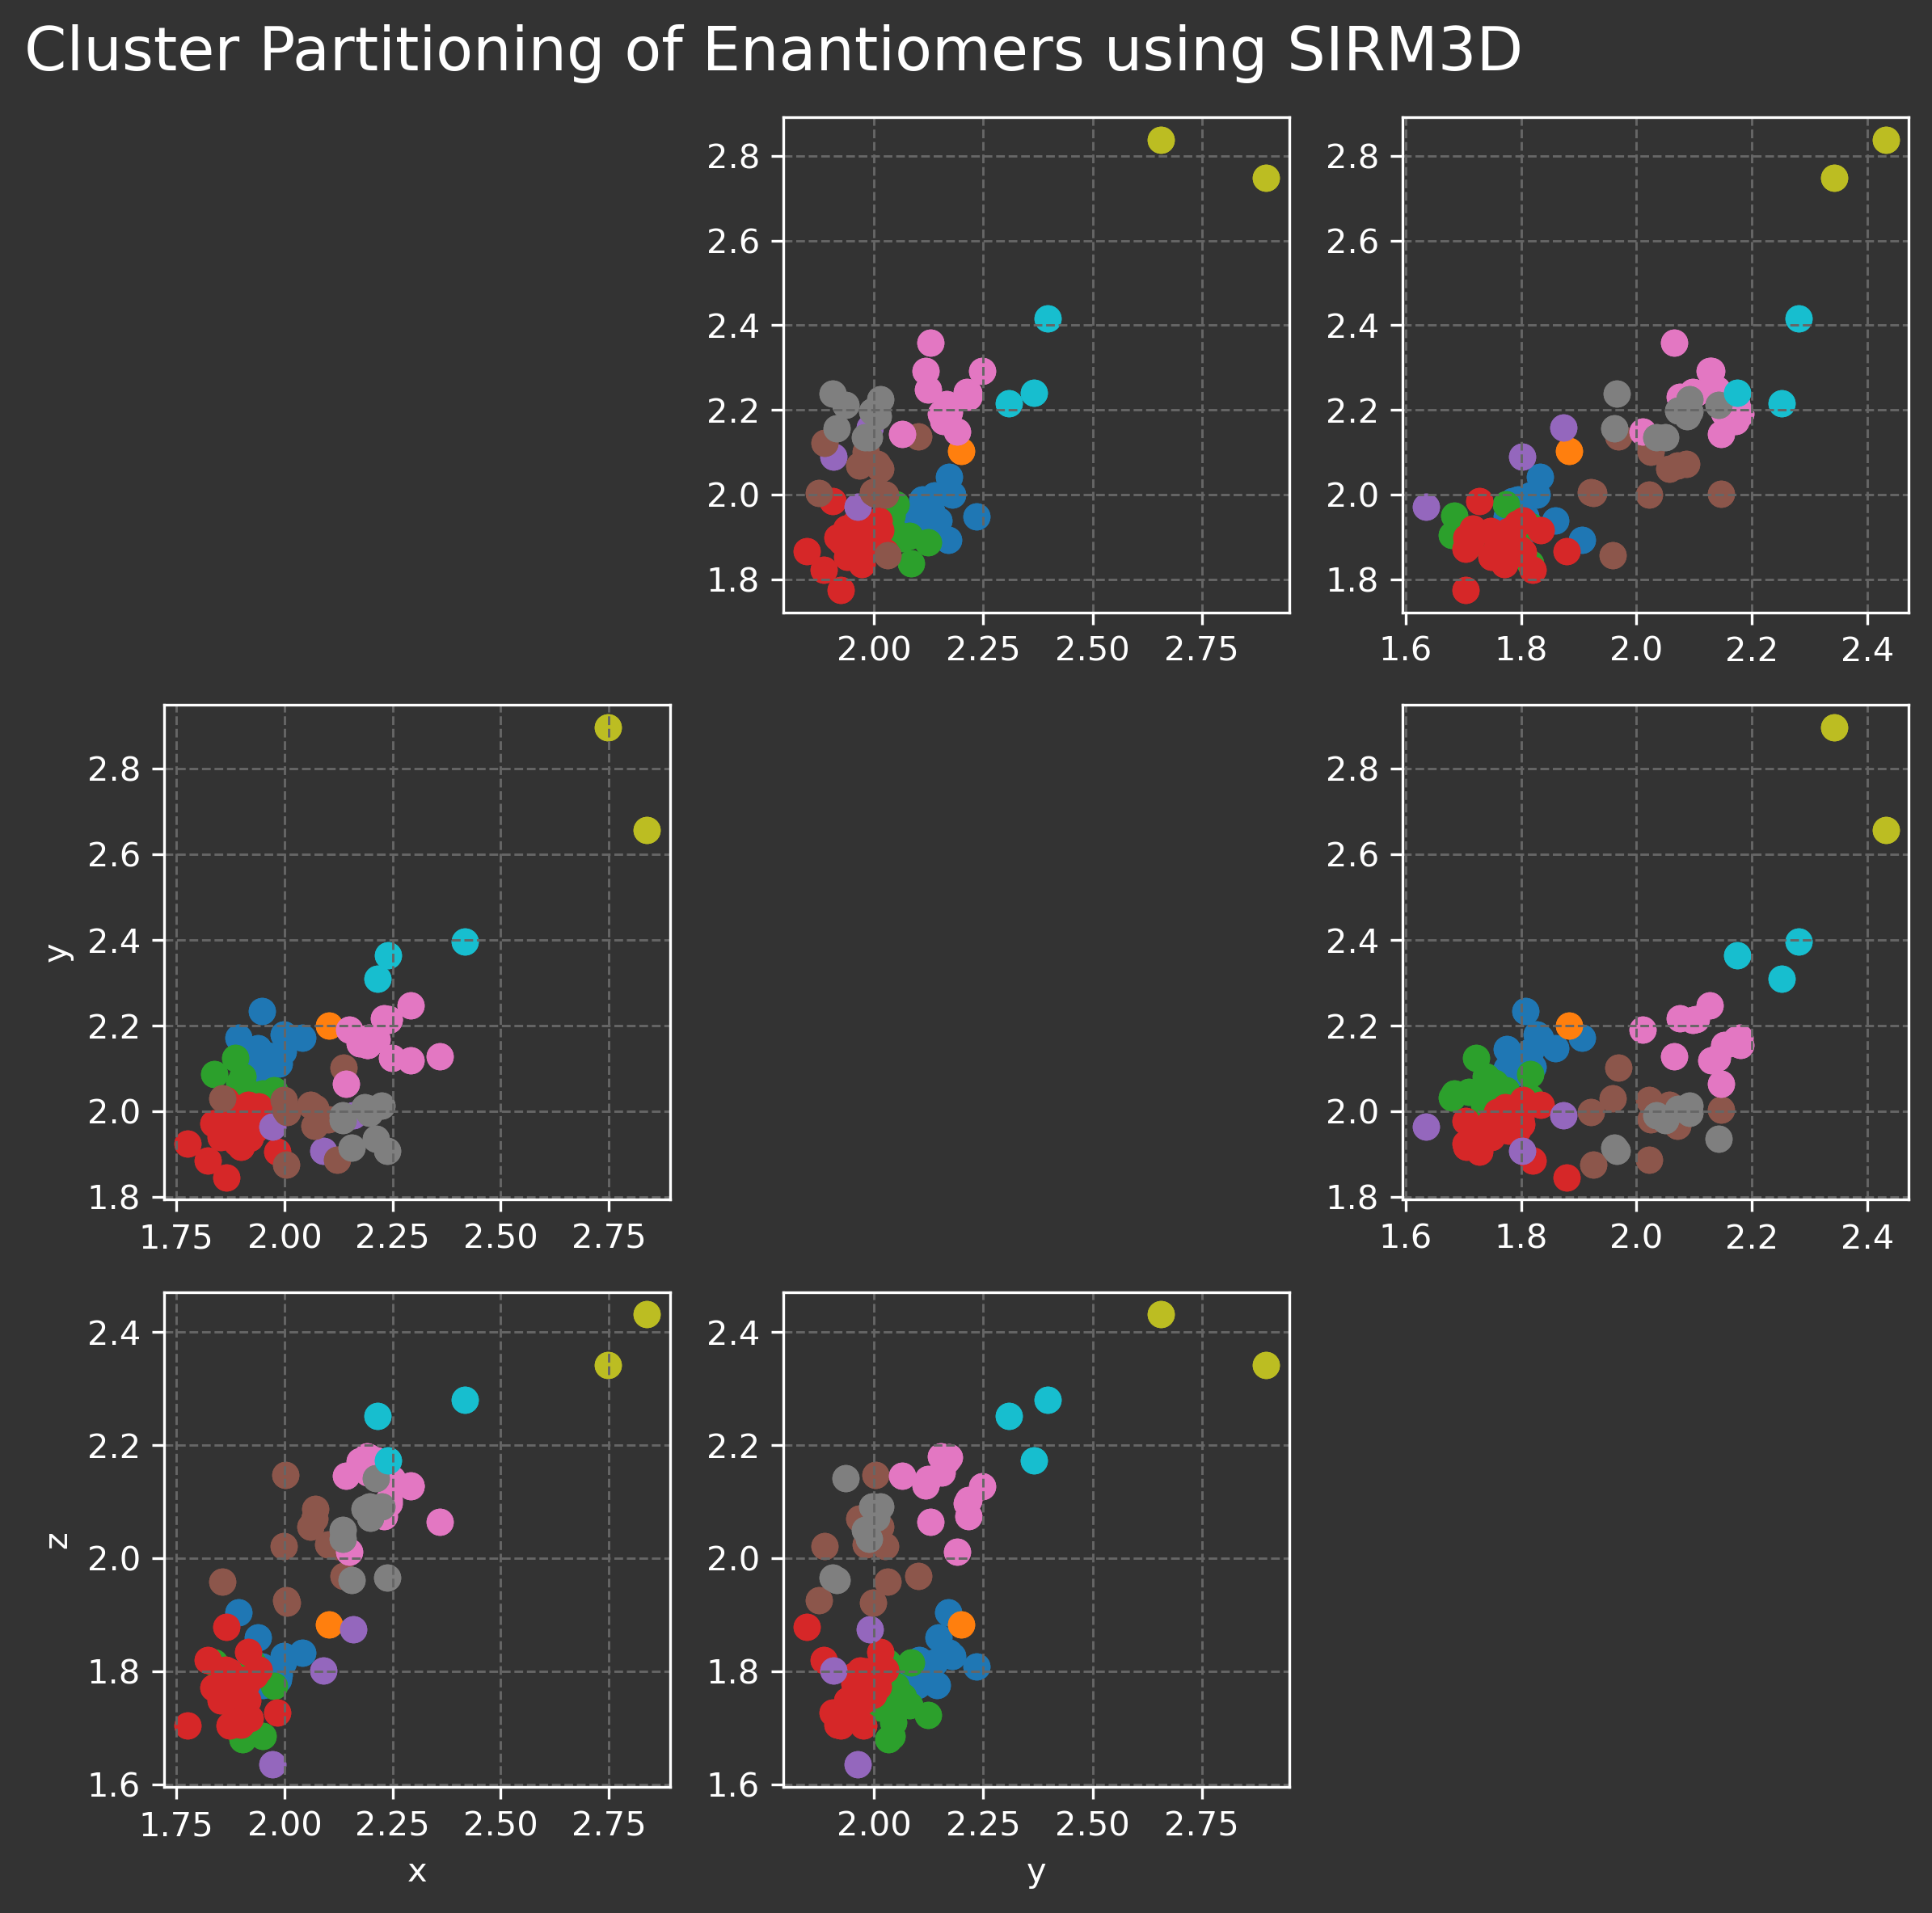

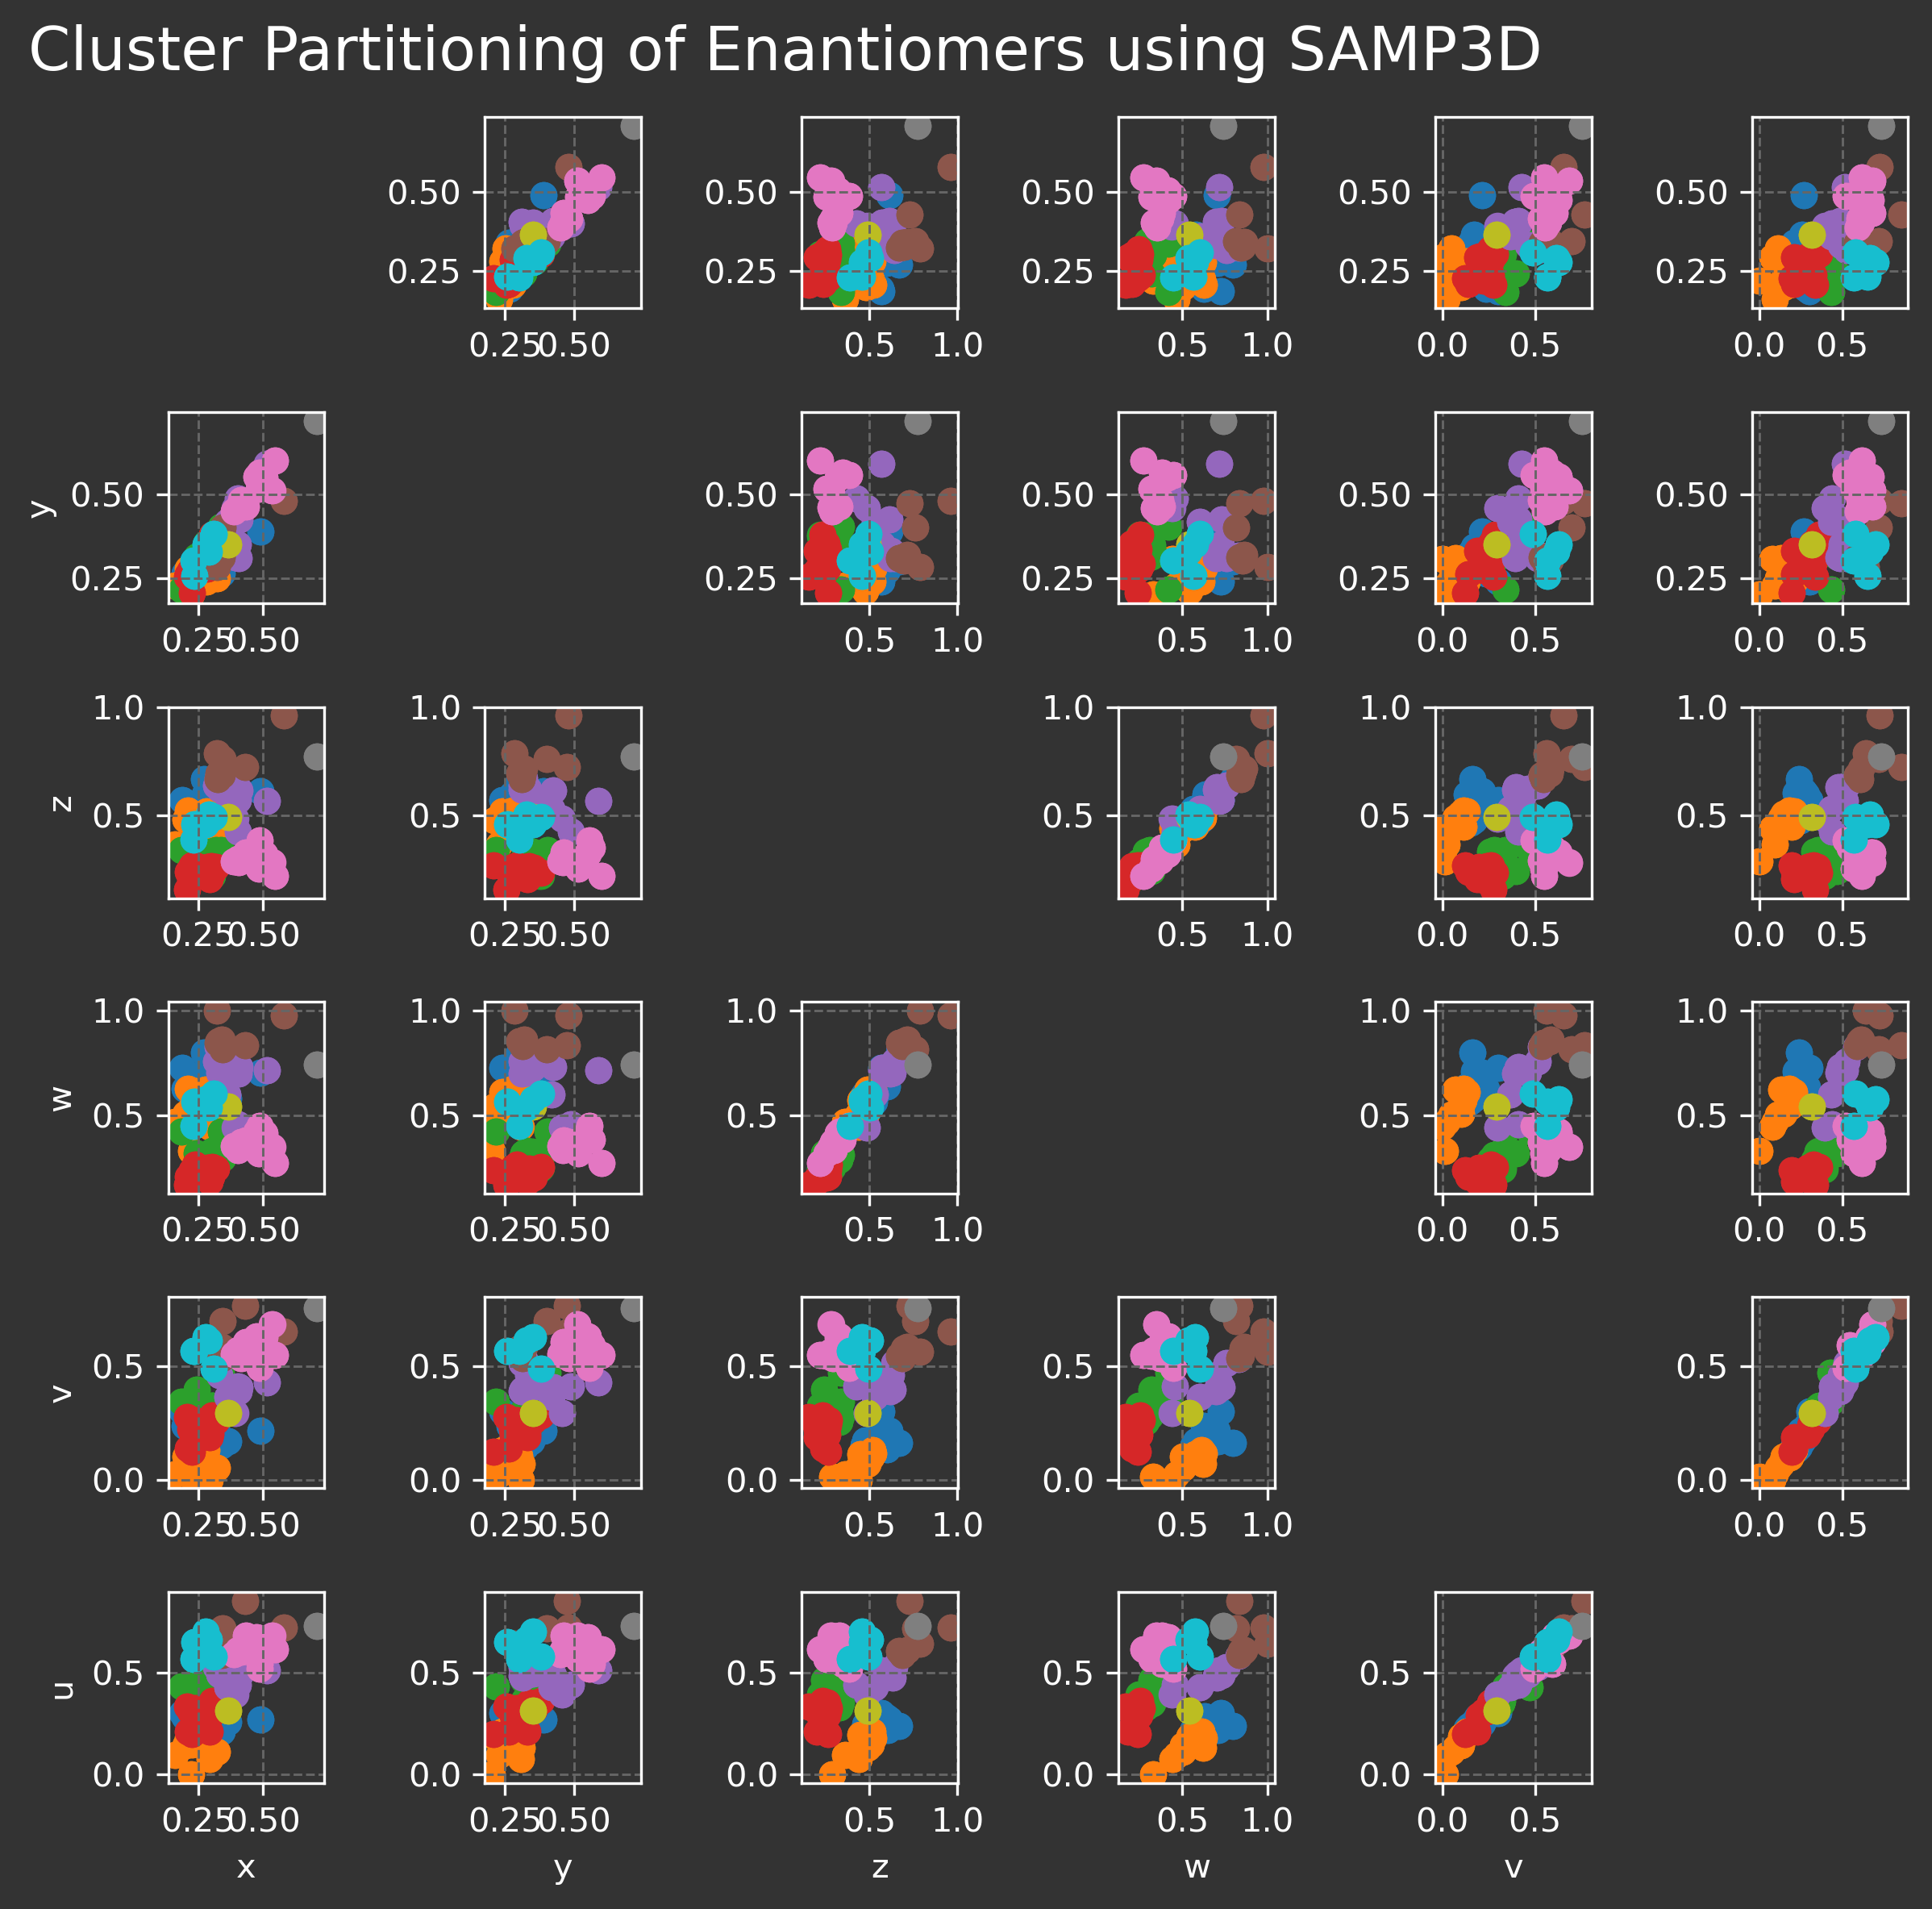

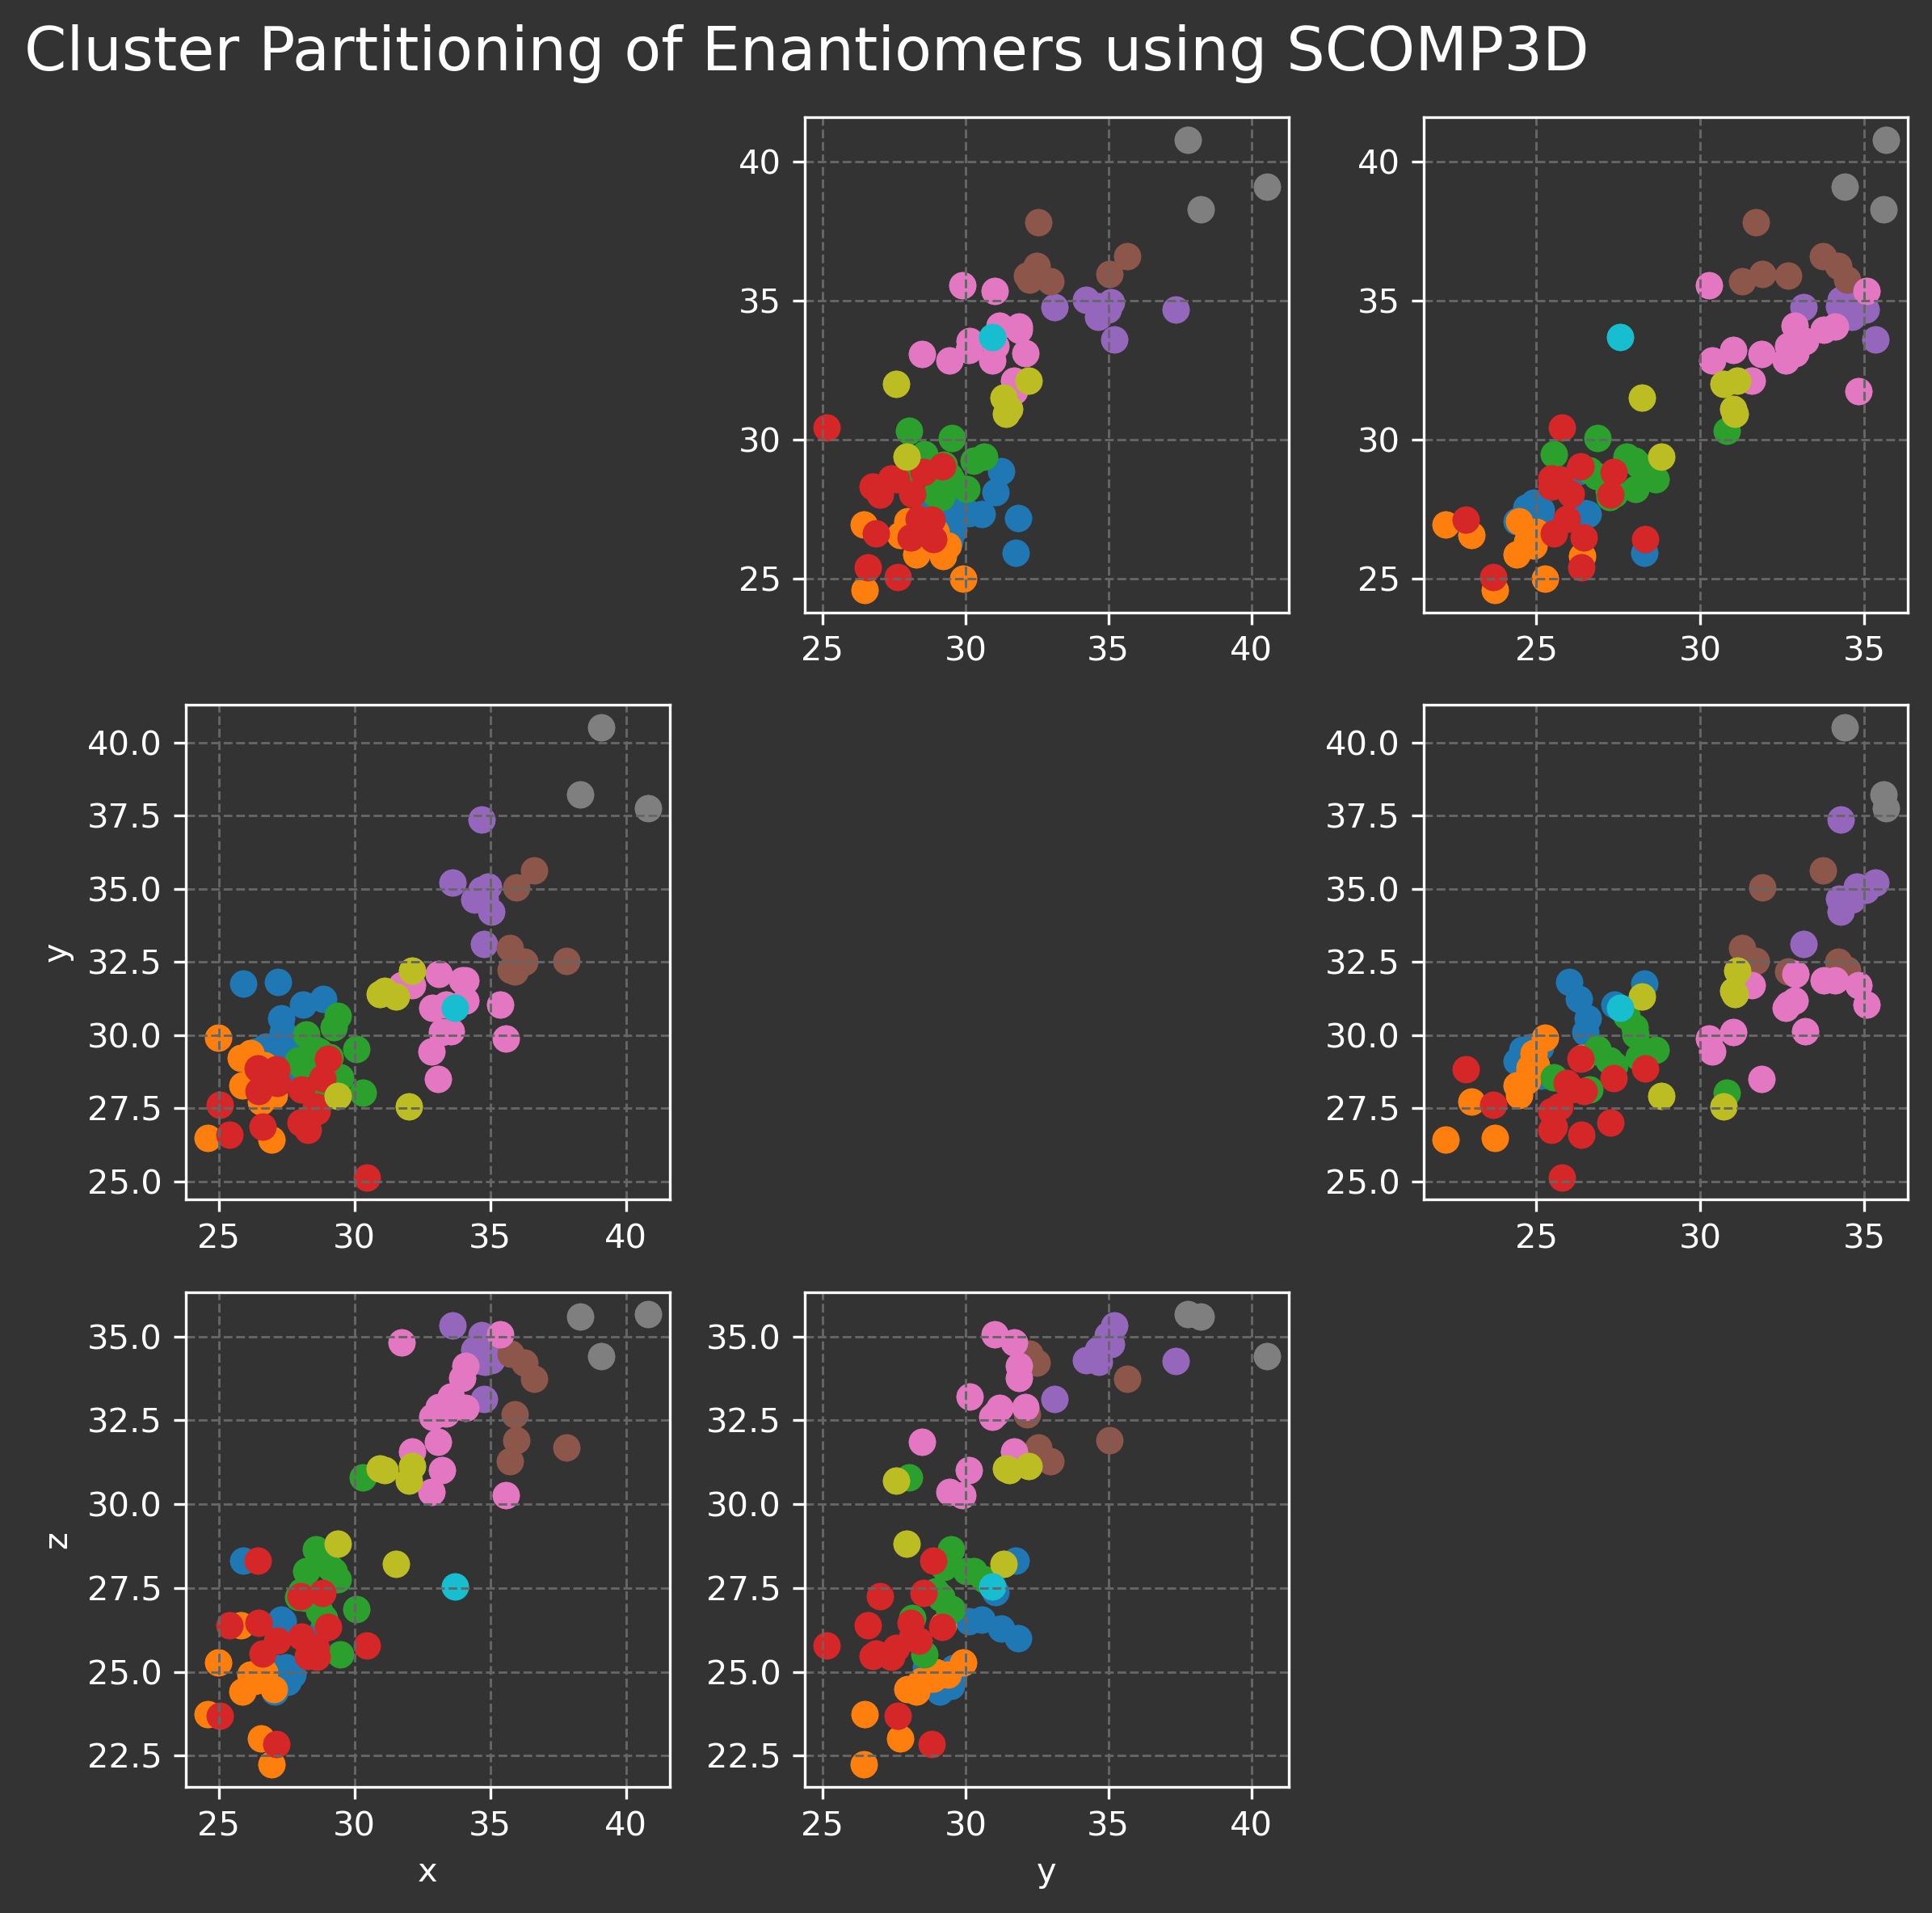

In [14]:
descriptors = ['evrap', 'sirm_3d', 'samp_3d', 'scomp_3d']
# for each descriptor create one plot
# each plot shows the clusters 3, 7, -3 and -7
# check how well the clustering worked

axis_labels = {
    0: 'x',
    1: 'y',
    2: 'z',
    3: 'w',
    4: 'v',
    5: 'u'
}

clusters = [-3, -7, 3, 7]
for descriptor in descriptors:
    # Get relevant data for plotting
    mirrored_clusters_idx = df['labels'].isin(clusters)
    mirrored_clusters = np.stack(df[mirrored_clusters_idx][descriptor].to_numpy())
    num_dims = mirrored_clusters.shape[1]

    # Prepare plot
    fig, axes = plt.subplots(num_dims, num_dims, figsize=(8, 8), dpi=300)
    title = f"Cluster Partitioning of Enantiomers using {descriptor.upper().replace('_', '')}"
    fig.suptitle(title, color="white", fontsize=18, x=0.01, horizontalalignment="left")

    # Compute clustering using best parameters
    label_file_name = f'test_output/proteins_mirrored_{descriptor}_connectivity_symmetric_k15_labelling.csv'
    if os.path.isfile(label_file_name):
        predicted_labels = pd.read_csv(label_file_name)
    else:
        knn_graph = compute_knn(df, descriptor_list=descriptor, n_neighbors=15, variant='symmetric',
                                mode='connectivity')
        spectral = SpectralClustering(
            n_clusters=11,
            affinity='precomputed',
            random_state=42,
            n_jobs=-1
        )
        predicted_labels = spectral.fit_predict(knn_graph)
        predicted_labels = pd.DataFrame(predicted_labels, columns=['labels'])
        predicted_labels.to_csv(label_file_name)
        
    predicted_labels = predicted_labels[mirrored_clusters_idx]['labels']
            
    for i in range(num_dims):
        for j in range(num_dims):
            ax = axes[j , i]
            if i == j:
                ax.set_visible(False)
                continue
            x_data = mirrored_clusters[:, i]
            y_data = mirrored_clusters[:, j]
            x_axis_label = axis_labels[i] if j == num_dims - 1 else ''
            y_axis_label = axis_labels[j] if i == 0 else ''
            create_scatterplot_2d(ax, x_data, y_data, predicted_labels, x_axis_label, y_axis_label)

    fig.patch.set_facecolor('#333333')
    fig.tight_layout()     
    plt.show()

As it seems, enantiomer can not be clustered using these descriptors, as the preprocessing aligns them back to the same representation. 